# Laboratorio 4 de Inteligencia Artificial: Redes Neuronales

### Integrantes grupo 11: 
- FELIPE ANTONIO BARJA CÁRCAMO
- CRISTIAN FELIPE BERNAL SALINAS
- SEBASTIÁN ALEJANDRO LILLO ACOSTA
- IGNACIO ANDRÉS VALDEBENITO CÁCERES

## Cargar librerias

In [79]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos

In [80]:
# Cargar los datos
df_red = pd.read_csv('winequality-red.csv', delimiter=';')

X = df_red.iloc[:, :-1].values
y = df_red.iloc[:, -1].values

In [81]:
categories = np.where(y < 5, 'lowquality', np.where(y == 5, 'average', 'highquality'))

label_encoder = LabelEncoder()
encoded_categories = label_encoder.fit_transform(categories)

## Análisis exploratorio de datos

En esta parte se generan múltiples diagramas de caja utilizando Seaborn para cada columna del dataframe df_red, mostrando la distribución de los valores de cada columna en función de la variable "quality" para finalmente, mostrarlo todo en un plot, que sería la matriz de correlación para vinos tintos.

In [82]:
df_red.describe() 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [83]:
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

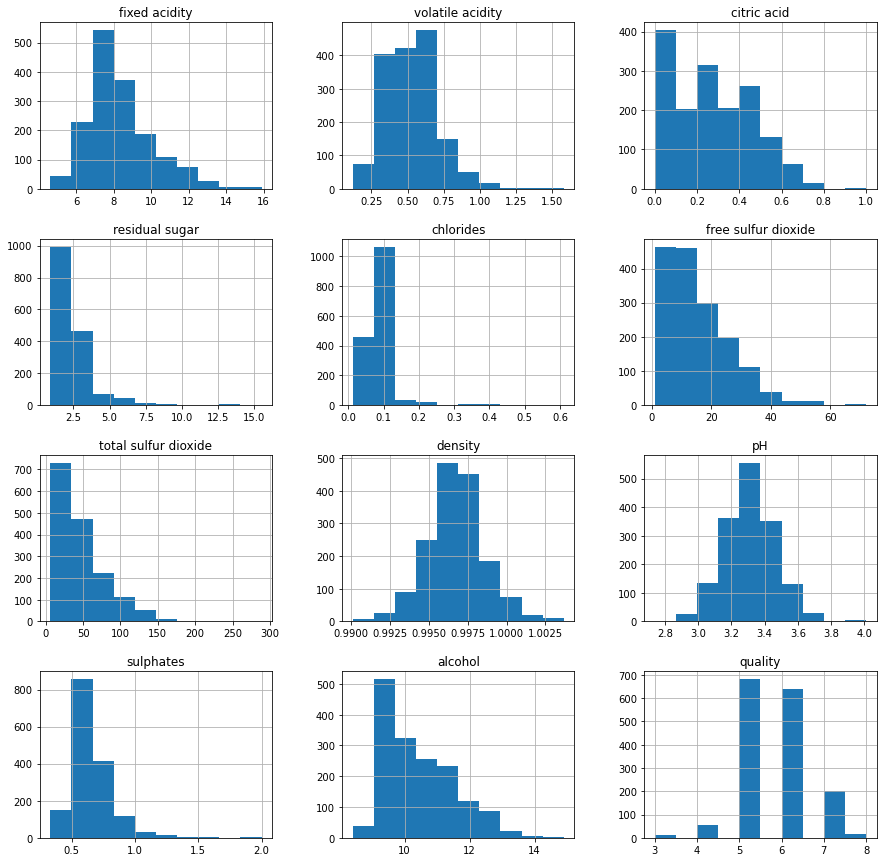

In [84]:
df_red.hist(figsize = (15,15))

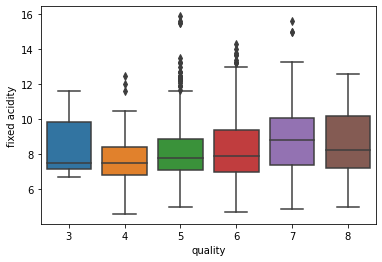

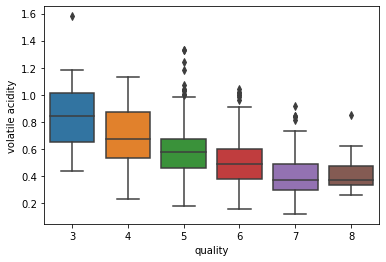

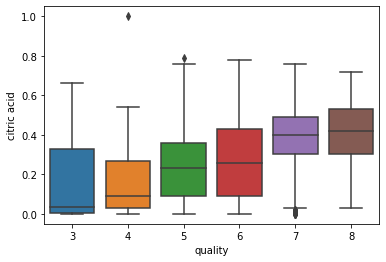

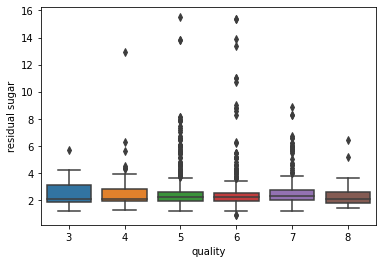

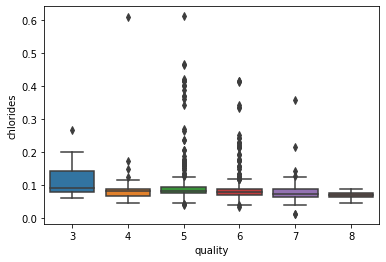

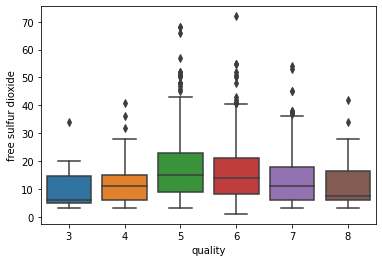

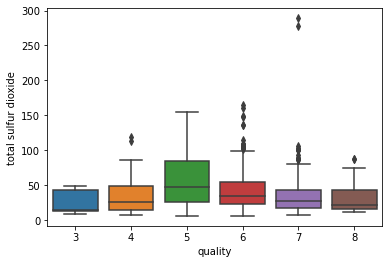

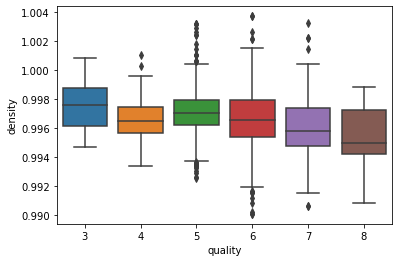

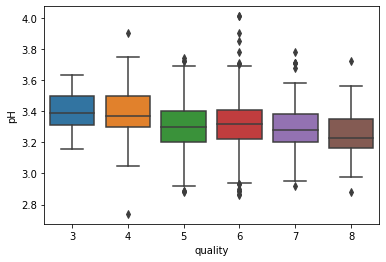

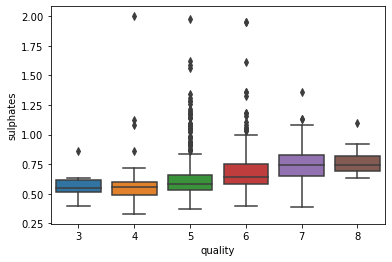

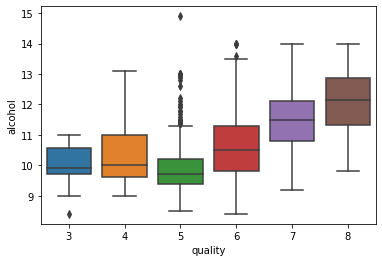

In [85]:
features = df_red.columns
for i in range(1,12):
    sns.boxplot(x='quality', y=features[i-1], data=df_red)
    plt.show()

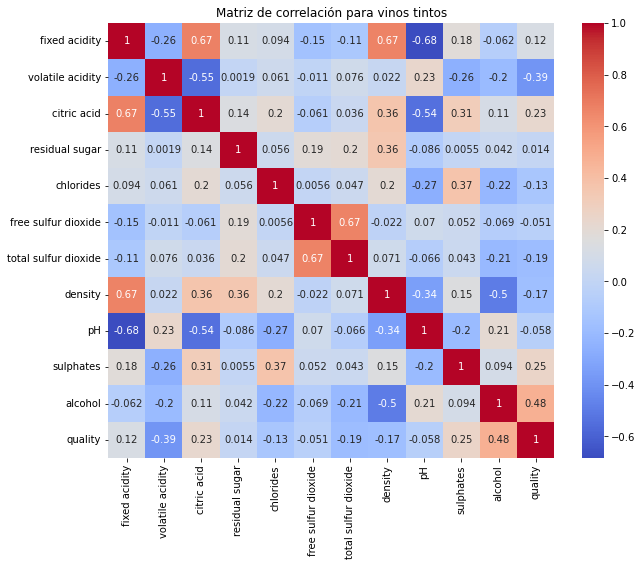

In [86]:
plt.figure(figsize=(10, 8))
correlation_red = df_red.corr()
sns.heatmap(correlation_red, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación para vinos tintos")
plt.show()

## Preprocesamiento de datos

En esta sección se realiza el preproceso de los datos. Primero se utiliza una función para categorizar la calidad de los vinos, siendo bajo un 5 de baja calidad, un 5 de calidad regular o promedio y sobre 5 de alta calidad. Luego, se codifican las etiquetas de calidad para finalmente, mostrar en un gráfico Plot la distriuciond y la calidad de los vinos.

Para el oversampleo, el código realiza un bucle sobre las clases minoritarias y, en cada iteración, selecciona aleatoriamente una muestra de la clase minoritaria actual con un tamaño igual al de la clase mayoritaria. Esto se hace para abordar el desequilibrio de clases en el conjunto de datos, generando muestras sintéticas de la clase minoritaria para igualar la cantidad de muestras de la clase mayoritaria. Finalmente, todas las muestras sobremuestreadas se concatenan en un único DataFrame llamado **oversampled_data.** Luego, en **"oversampled_data = pd.concat([oversampled_data, majority_data])"** se combinan los datos sobremuestreados con los datos de la clase mayoritaria, creando así un único DataFrame que representa el conjunto de datos final con el desequilibrio de clases abordado. Luego se mezclan aleatoriamente las filas de **oversampled_data** y se crea un nuevo DataFrame llamado **oversampled_redwine_df.**

Luego, se calcula la proporción de cada valor de calidad en el DataFrame **oversampled_data** y luego visualiza la distribución de la calidad de los vinos tintos en el DataFrame **oversampled_redwine_df** mediante un gráfico de barras.

Luego se separan las características de las etiquetas y se escalan para su posterior entrenamiento.

In [87]:
def categorize_quality(quality):
    if quality < 5:
        return 'LowQuality'
    elif quality == 5:
        return 'Average'
    else:
        return 'HighQuality'

In [88]:
df_red_copy = df_red.copy()

In [89]:
# Aplicamos la función a los datasets
df_red['quality'] = df_red['quality'].apply(categorize_quality)

In [90]:
# Codificando las etiquetas
le = LabelEncoder()
df_red['quality'] = le.fit_transform(df_red['quality'])

1    53.470919
0    42.589118
2     3.939962
Name: quality, dtype: float64


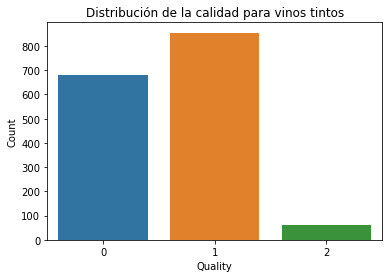

In [91]:
total_samples = len(df_red)
label_counts = df_red['quality'].value_counts()
label_proportions = label_counts / total_samples * 100
print(label_proportions)
plt.figure(figsize=(6, 4))
sns.countplot(x='quality', data=df_red)
plt.title("Distribución de la calidad para vinos tintos")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

In [92]:
minority_classes = [0,2]

In [93]:
minority_data = df_red[df_red['quality'].isin(minority_classes)]
majority_data = df_red[~df_red['quality'].isin(minority_classes)]

In [94]:
n_samples_majority = len(majority_data)

In [95]:
oversampled_data = pd.concat([
    minority_data[minority_data['quality'] == cls].sample(
        n=n_samples_majority, replace=True, random_state=42)
    for cls in minority_classes
])

In [96]:
oversampled_data = pd.concat([oversampled_data, majority_data])

In [97]:
oversampled_redwine_df = shuffle(oversampled_data, random_state=42)

0    33.333333
2    33.333333
1    33.333333
Name: quality, dtype: float64


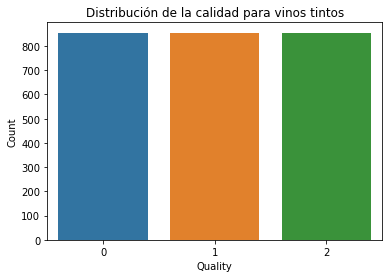

In [98]:
total_samples = len(oversampled_redwine_df)
label_counts = oversampled_data['quality'].value_counts()
label_proportions = label_counts / total_samples * 100
print(label_proportions)

# Distribución de la calidad
plt.figure(figsize=(6, 4))
sns.countplot(x='quality', data=oversampled_redwine_df)
plt.title("Distribución de la calidad para vinos tintos")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

In [99]:
# Separando las características de las etiquetas
X_red = oversampled_redwine_df.drop('quality', axis=1)
y_red = oversampled_redwine_df['quality']

In [100]:
# Escalando las características
scaler = StandardScaler()
X_red = scaler.fit_transform(X_red)

In [101]:
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size=0.2, random_state=42)

## Modelo de clasificación con Red Neuronal (Función sigmoidal)

En la primera sección, se implementa un procedimiento de validación cruzada k-fold para evaluar un modelo de red neuronal utilizando las métricas de precisión y pérdida. El modelo se entrena y evalúa en cada fold, y se almacenan los puntajes obtenidos. Finalmente, se calcula y se muestra el puntaje promedio de precisión del modelo en todos los folds. Siguiente a eso, se calcula la matriz de confusión utilizando las etiquetas verdaderas y las etiquetas predichas, y luego muestra la matriz de confusión en forma de mapa de calor. Esto proporciona una visualización útil para analizar el desempeño del modelo de clasificación.

Finalmente, se trazan las curvas de precisión, pérdida, precisión de validación y pérdida de validación en función de las épocas del entrenamiento del modelo de red neuronal. Estas curvas proporcionan una visualización de cómo evolucionan estas métricas a medida que el modelo se entrena y puede ser útil para analizar el rendimiento y el ajuste del modelo.

In [102]:
k = 5 
kfold = KFold(n_splits=k, shuffle=True, random_state=1) #

# Almacenar los puntajes de cada iteración
scores = []
accuracy_list = []
loss = []
val_loss = []
val_accuracy = []

# Convertir a arrays de NumPy
X_red_np = np.array(X_red)
y_red_np = keras.utils.to_categorical(np.array(y_red))

# Loop para cada fold
for train, test in kfold.split(X_red_np):  #En cada iteración, se obtienen los índices de entrenamiento y prueba correspondientes al fold actual.
    # Crear el modelo
    model = keras.models.Sequential([
        keras.layers.Dense(256, activation="sigmoid",
                        input_shape=(X_red_np.shape[1],)),
        keras.layers.Dense(128, activation="sigmoid"),
        keras.layers.Dense(3, activation="softmax")
    ])

    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en los datos de entrenamiento
    cl = model.fit(X_red_np[train], y_red_np[train], epochs=50,
                   batch_size=32, verbose=1, validation_split=0.2)

    accuracy_list = cl.history['accuracy']
    loss = cl.history['loss']
    val_loss = cl.history['val_loss']
    val_accuracy = cl.history['val_accuracy']

    # Evaluar el modelo en los datos de prueba
    score = model.evaluate(X_red_np[test], y_red_np[test], verbose=1)
    scores.append(score[1])

# Calcular y imprimir el puntaje promedio
average_score = np.mean(scores)
print('Average score:', average_score)


Epoch 1/50


52/52 [==============================] - 1s 4ms/step - loss: 1.0995 - accuracy: 0.4071 - val_loss: 1.0116 - val_accuracy: 0.6034
Epoch 2/50
52/52 [==============================] - 0s 2ms/step - loss: 0.9791 - accuracy: 0.5582 - val_loss: 0.9297 - val_accuracy: 0.6083
Epoch 3/50
52/52 [==============================] - 0s 2ms/step - loss: 0.9114 - accuracy: 0.5905 - val_loss: 0.8946 - val_accuracy: 0.6107
Epoch 4/50
52/52 [==============================] - 0s 2ms/step - loss: 0.8858 - accuracy: 0.5917 - val_loss: 0.8700 - val_accuracy: 0.6131
Epoch 5/50
52/52 [==============================] - 0s 3ms/step - loss: 0.8701 - accuracy: 0.5972 - val_loss: 0.8693 - val_accuracy: 0.5888
Epoch 6/50
52/52 [==============================] - 0s 2ms/step - loss: 0.8601 - accuracy: 0.6069 - val_loss: 0.8606 - val_accuracy: 0.6204
Epoch 7/50
52/52 [==============================] - 0s 2ms/step - loss: 0.8528 - accuracy: 0.6228 - val_loss: 0.8319 - val_accuracy: 0.6375
Epoch 8/50
52/52 [=============

17/17 [==============================] - 0s 1ms/step


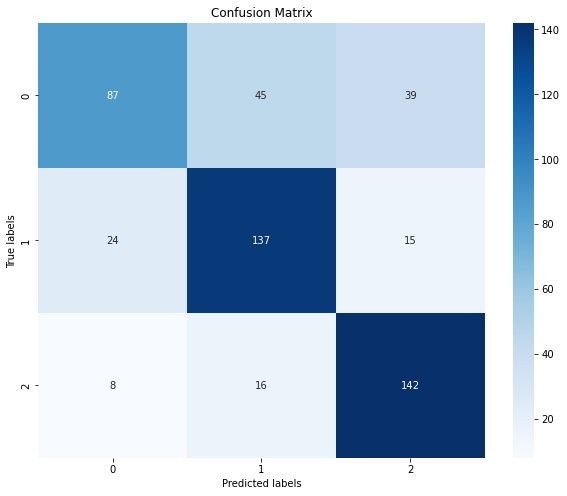

In [103]:
p_test = model.predict(X_red_test).argmax(axis=1)
cm = tf.math.confusion_matrix(y_red_test, p_test)

cm_array = cm.numpy()

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar la matriz de confusión
sns.heatmap(cm_array, annot=True, cmap='Blues', fmt='d', ax=ax)

# Configurar las etiquetas de los ejes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Mostrar la figura
plt.show()

In [104]:
def calculate_metrics(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    metrics = []

    for i in range(num_classes):
        TP = confusion_matrix[i, i]
        FP = np.sum(confusion_matrix[:, i]) - TP
        FN = np.sum(confusion_matrix[i, :]) - TP
        TN = np.sum(confusion_matrix) - TP - FP - FN

        metrics.append((TP, FP, FN, TN))

    return metrics

In [105]:
metrics = calculate_metrics(cm_array)

In [106]:
mean_accuracy = 0

for i, (TP, FP, FN, TN) in enumerate(metrics):
    print("Resultados clase "+str(i))
    # Cálculo de métricas a partir de los valores de TP, FP, FN y TN
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1_score = 2 * (precision * recall) / (precision + recall)

    mean_accuracy += accuracy
    # Imprimir las métricas
    print("Exactitud (Accuracy):", accuracy)
    print("Precisión (Precision):", precision)
    print("Recall / Sensibilidad (Recall):", recall)
    print("Especificidad (Specificity):", specificity)
    print("Valor F1 (F1 Score):", f1_score)

print(mean_accuracy/3)


Resultados clase 0
Exactitud (Accuracy): 0.7738791423001949
Precisión (Precision): 0.7310924369747899
Recall / Sensibilidad (Recall): 0.5087719298245614
Especificidad (Specificity): 0.9064327485380117
Valor F1 (F1 Score): 0.6
Resultados clase 1
Exactitud (Accuracy): 0.8050682261208577
Precisión (Precision): 0.6919191919191919
Recall / Sensibilidad (Recall): 0.7784090909090909
Especificidad (Specificity): 0.8189910979228486
Valor F1 (F1 Score): 0.732620320855615
Resultados clase 2
Exactitud (Accuracy): 0.847953216374269
Precisión (Precision): 0.7244897959183674
Recall / Sensibilidad (Recall): 0.8554216867469879
Especificidad (Specificity): 0.8443804034582133
Valor F1 (F1 Score): 0.7845303867403315
0.8089668615984406


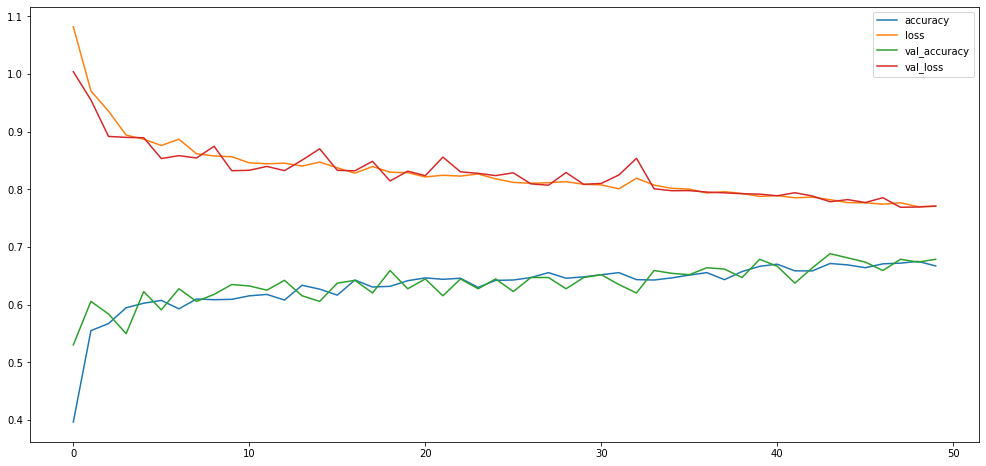

In [107]:
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(accuracy_list, label='accuracy')
plt.plot(loss,label='loss')
plt.plot(val_accuracy,label='val_accuracy')
plt.plot(val_loss,label='val_loss')
plt.legend()

## Modelo de clasificación con Red neuronal (Función tangente hiperbólica) 

Se realiza una validación mediante K-fold para evaluar un modelo de red neuronal utilizando la función de tangente hiperbólica (tanh) en cada una de sus capas ocultas. El modelo se entrena y evalúa en cada fold para almacenar luego los puntajes obtenidos. Finalmente, se calcula y se muestra el puntaje promedio de precisión del modelo en todos los folds. Luego, se calcula la matriz de confusión a través de las etiquetas **p_test** y **y_red_test**. Finalmente se crea una visualización de la matriz de confusión con un mapa de calor. La matriz de confusión muestra el número de predicciones correctas e incorrectas para cada clase y es una herramienta útil para evaluar el rendimiento de un modelo de clasificación.

Por último, el código plotea las curvas de precisión, pérdida, precisión de validación y pérdida de validación en un gráfico para visualizar el rendimiento del modelo durante el entrenamiento. La visualización de estas curvas puede proporcionar información sobre cómo está aprendiendo el modelo y si hay signos de sobreajuste (overfitting) o subajuste (underfitting).



In [108]:
# Definir el procedimiento de k-fold cross validation
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=1)

# Almacenar los puntajes de cada iteración
scores = []
accuracy_list = []
loss = []
val_loss = []
val_accuracy = []

# Convertir a arrays de NumPy
X_red_np = np.array(X_red)
y_red_np = keras.utils.to_categorical(np.array(y_red))

# Loop para cada fold
for train, test in kfold.split(X_red_np):
    # Crear el modelo
    model = Sequential([
        Dense(256, activation="tanh",input_shape=(X_red_np.shape[1],)),
        Dense(128, activation="tanh"),
        Dense(3, activation="softmax")
    ])

    # Compilar el modelo
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    # Entrenar el modelo en los datos de entrenamiento
    cl = model.fit(X_red_np[train], y_red_np[train], epochs=100,
                   batch_size=32, verbose=0, validation_split=0.2)

    accuracy_list = cl.history['accuracy']
    loss = cl.history['loss']
    val_loss = cl.history['val_loss']
    val_accuracy = cl.history['val_accuracy']

    # Evaluar el modelo en los datos de prueba
    score = model.evaluate(X_red_np[test], y_red_np[test], verbose=0)
    scores.append(score[1])

# Calcular y imprimir el puntaje promedio
average_score = np.mean(scores)
print('Average score:', average_score)


Average score: 0.8865496993064881


17/17 [==============================] - 0s 1ms/step


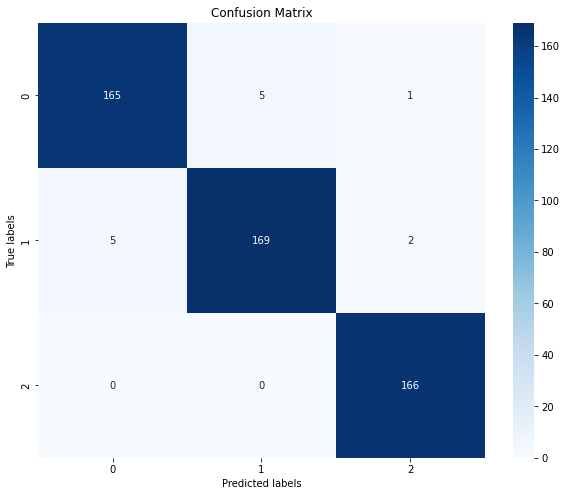

In [109]:
p_test = model.predict(X_red_test).argmax(axis=1)
cm = tf.math.confusion_matrix(y_red_test, p_test)

cm_array = cm.numpy()

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar la matriz de confusión
sns.heatmap(cm_array, annot=True, cmap='Blues', fmt='d', ax=ax)

# Configurar las etiquetas de los ejes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Mostrar la figura
plt.show()

In [110]:
def calculate_metrics(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    metrics = []

    for i in range(num_classes):
        TP = confusion_matrix[i, i]
        FP = np.sum(confusion_matrix[:, i]) - TP
        FN = np.sum(confusion_matrix[i, :]) - TP
        TN = np.sum(confusion_matrix) - TP - FP - FN

        metrics.append((TP, FP, FN, TN))

    return metrics

In [111]:
metrics = calculate_metrics(cm_array)

In [112]:
mean_accuracy = 0

for i, (TP, FP, FN, TN) in enumerate(metrics):
    print("Resultados clase "+str(i))
    # Cálculo de métricas a partir de los valores de TP, FP, FN y TN
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1_score = 2 * (precision * recall) / (precision + recall)

    mean_accuracy += accuracy
    # Imprimir las métricas
    print("Exactitud (Accuracy):", accuracy)
    print("Precisión (Precision):", precision)
    print("Recall / Sensibilidad (Recall):", recall)
    print("Especificidad (Specificity):", specificity)
    print("Valor F1 (F1 Score):", f1_score)

print(mean_accuracy/3)

Resultados clase 0
Exactitud (Accuracy): 0.9785575048732943
Precisión (Precision): 0.9705882352941176
Recall / Sensibilidad (Recall): 0.9649122807017544
Especificidad (Specificity): 0.9853801169590644
Valor F1 (F1 Score): 0.967741935483871
Resultados clase 1
Exactitud (Accuracy): 0.9766081871345029
Precisión (Precision): 0.9712643678160919
Recall / Sensibilidad (Recall): 0.9602272727272727
Especificidad (Specificity): 0.9851632047477745
Valor F1 (F1 Score): 0.9657142857142857
Resultados clase 2
Exactitud (Accuracy): 0.9941520467836257
Precisión (Precision): 0.9822485207100592
Recall / Sensibilidad (Recall): 1.0
Especificidad (Specificity): 0.9913544668587896
Valor F1 (F1 Score): 0.9910447761194029
0.9831059129304743


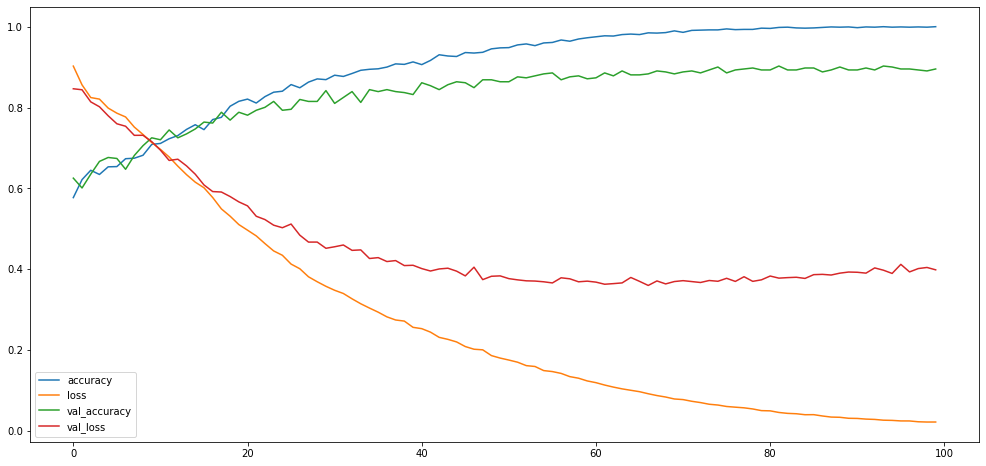

In [113]:
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(accuracy_list, label='accuracy')
plt.plot(loss,label='loss')
plt.plot(val_accuracy,label='val_accuracy')
plt.plot(val_loss,label='val_loss')
plt.legend()

## Modelo de regresión con Red Neuronal (Función sigmoidal)

El modelo consta de varias capas que procesan estos datos y aprenden patrones subyacentes en ellos. Las primeras capas son capas densas, lo que significa que cada neurona está conectada con todas las neuronas de la capa anterior. Estas capas densas se utilizan para extraer características relevantes de los datos y realizar transformaciones no lineales en ellos.

Las capas ocultas tienen una cantidad de neuronas especificada, en este caso, 256 y 128 respectivamente. Cada neurona utiliza una función de activación, que es una función matemática que introduce no linealidades en el modelo y permite que este aprenda relaciones más complejas en los datos.


Finalmente, la capa de salida tiene una sola neurona, ya que estamos realizando una tarea de regresión para predecir la calidad del vino. No se aplica ninguna función de activación en esta capa, ya que queremos obtener una salida continua que represente la calidad del vino.

El modelo se entrena utilizando un algoritmo llamado "adam" como optimizador, que ajusta los pesos y sesgos de las neuronas para minimizar la función de pérdida "mean_squared_error" (error cuadrático medio). Esto implica que el modelo buscará minimizar la discrepancia entre las predicciones que realiza y los valores reales de calidad del vino.

In [114]:
def create_model(act_function):
    # Crear el modelo de red neuronal
    model = Sequential()
    model.add(Dense(256, activation=act_function, input_shape=(X.shape[1],)))
    model.add(Dense(128, activation=act_function))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mse', 'mae'])

    return model

Normalizar los datos

In [115]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Se dividen los datos en set de entrenamiento y prueba.

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X,encoded_categories,test_size=0.2,random_state=42)

Realizar validación cruzada con k-fold

In [117]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

El bucle for recorre cada iteración de k-fold, dividiendo los datos de entrenamiento y prueba según los índices generados por kfold.split(X_train). En cada iteración, se seleccionan los conjuntos de entrenamiento y prueba correspondientes.

Dentro del bucle, se crea un modelo de red neuronal utilizando la función create_model. En este caso, se utiliza la función de activación 'sigmoid' en las capas ocultas.

A continuación, el modelo se entrena utilizando los datos de entrenamiento (X_train e y_train) durante 40 épocas, con un tamaño de lote de 32.

El historial de entrenamiento (history) se guarda en la lista history_list en cada iteración.

Después de entrenar el modelo, se evalúa su rendimiento en el conjunto de prueba (X_test e y_test) utilizando la función evaluate. El resultado se guarda en la lista mse_scores, que contiene el error cuadrático medio (MSE) obtenido en cada iteración.

In [118]:
mse_scores = []
history_list = []

for train_index, test_index in kfold.split(X_train):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = encoded_categories[train_index], encoded_categories[test_index]

    model = create_model('sigmoid')
    
    # Entrenar el modelo de red neuronal
    history = model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=0)

    history_list.append(history)

    # Evaluar el modelo en el conjunto de prueba
    mse = model.evaluate(X_test, y_test, verbose=0)
    mse_scores.append(mse)

Una vez finalizadas todas las iteraciones de k-fold, se calcula el MSE promedio y su desviación estándar a partir de los valores almacenados en mse_scores. Estos valores se imprimen en pantalla para evaluar el rendimiento general del modelo.

In [119]:
mse_mean = np.mean(mse_scores)
mse_std = np.std(mse_scores)
print("MSE Promedio: ", mse_mean)
print("Desviación Estándar MSE: ", mse_std)

MSE Promedio:  0.3039029637972514
Desviación Estándar MSE:  0.07714936113508782


Se muestra la función de costo del modelo (MSE) y su comportamiento en una de las iteraciones de k-fold.

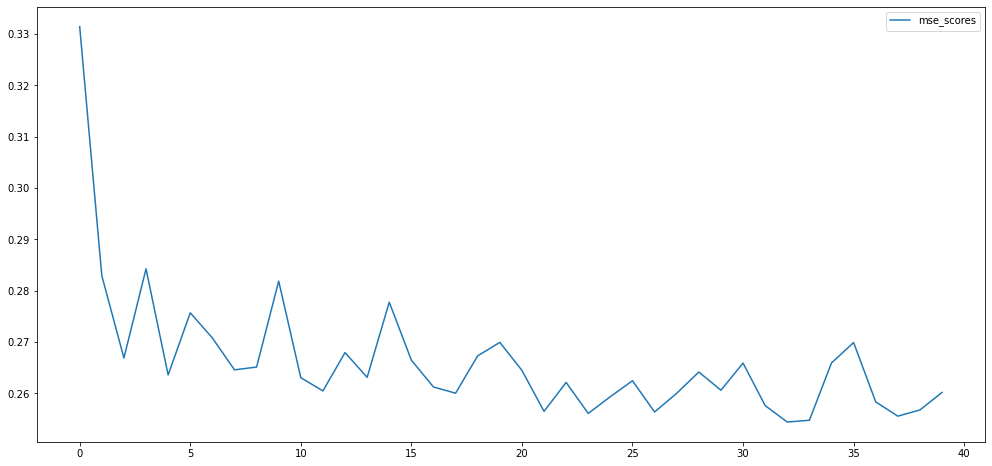

In [120]:
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(history_list[-1].history['loss'], label='mse_scores')
plt.legend()

Se realizan las predicciones

In [121]:
predictions = model.predict(X_test)

8/8 [==============================] - 0s 2ms/step


Se grafican las predicciones con respecto a los valores verdaderos del set de prueba. El modelo, a primera vista parece ajustarse medianamente, y aunque existen algunos outliers, siguen el patrón general de distribución del conjunto de valores reales.

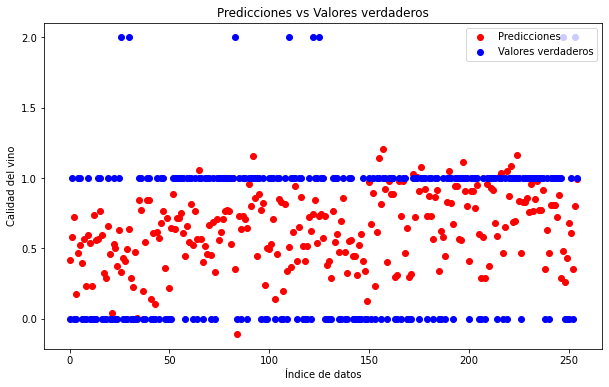

In [122]:
indices = np.arange(len(X_test))

# Graficar las predicciones
plt.figure(figsize=(10, 6))
plt.scatter(indices, predictions, color='red', label='Predicciones')
plt.scatter(indices, y_test, color='blue', label='Valores verdaderos')
plt.xlabel('Índice de datos')
plt.ylabel('Calidad del vino')
plt.title('Predicciones vs Valores verdaderos')
plt.legend()
plt.show()

## Modelo de regresión con Red Neuronal (Función tangente hiperbólica)

Este código implementa una validación cruzada con k-fold para entrenar y evaluar un modelo de red neuronal. Aquí está la descripción de cada parte del código y su propósito:

En el siguiente codigo se almacenarán los historiales de entrenamiento de cada iteración de k-fold. Entoces, se itera por cada subconjunto de entrenamiento y prueba para cada k-fold. Luego se crea el modelo de red neuronal utilizando la funcion `create_model()` con una funcion de activación `tanh`. Después, se entrena el modelo de red neuronal con la función `fit()` en los datos de entrenamiento (X_train e y_train) durante 40 épocas, utilizando un tamaño de lote de 32. El historial de entrenamiento se guarda en la variable `history`.

Para obtener los costos de entrenamiento, se calcula el error cuadrático medio (MSE), utilizando la función `evaluate()`del modelo. Se guarda el valor evaluado y se guarda en la lista de mse_scores. Finalmente se calcula el MSE promedio y la desviación estándar de los MSE obtenidos en cada iteración.

In [123]:
history_list = []

for train_index, test_index in kfold.split(X_train):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = encoded_categories[train_index], encoded_categories[test_index]

    model = create_model('tanh')
    
    # Entrenar el modelo de red neuronal
    history = model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=0)

    history_list.append(history)

    # Evaluar el modelo en el conjunto de prueba
    mse = model.evaluate(X_test, y_test, verbose=0)
    mse_scores.append(mse)

# Imprimir el error cuadrático medio medio y su desviación estándar
mse_mean = np.mean(mse_scores)
mse_std = np.std(mse_scores)
print("MSE Promedio: ", mse_mean)
print("Desviación Estándar MSE: ", mse_std)

MSE Promedio:  0.3163956185181936
Desviación Estándar MSE:  0.07318370126142684


En este apartado, se observa el comportamiento de la función de costo del entrenamiento en la última iteración de K-fold. 

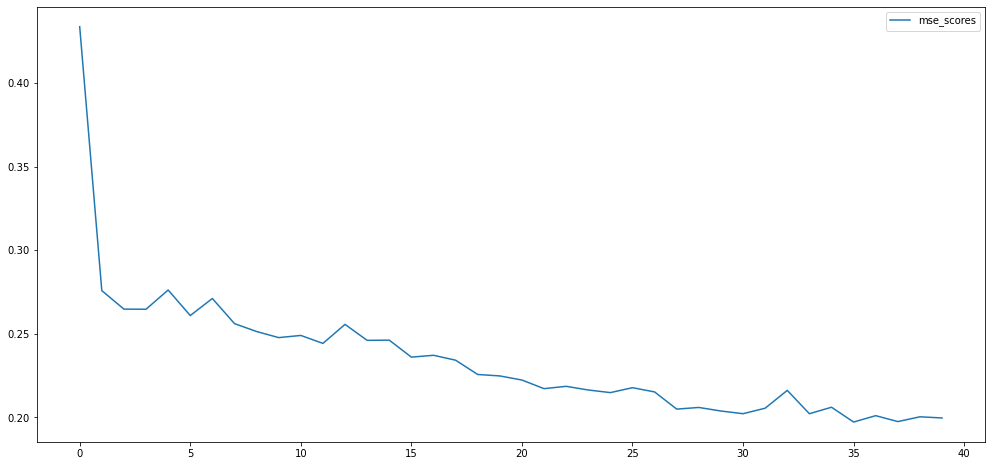

In [124]:
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(history_list[-1].history['loss'], label='mse_scores')
plt.legend()

Se realizan las predicciones con el conjunto de testing.

In [125]:
# Realizar predicciones
predictions = model.predict(X_test)

1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 1ms/step


Se grafican las predicciones con respecto a los valores verdaderos del set de prueba. El modelo, a primera vista parece ajustarse medianamente, y aunque existen algunos outliers, siguen el patrón general de distribución del conjunto de valores reales.

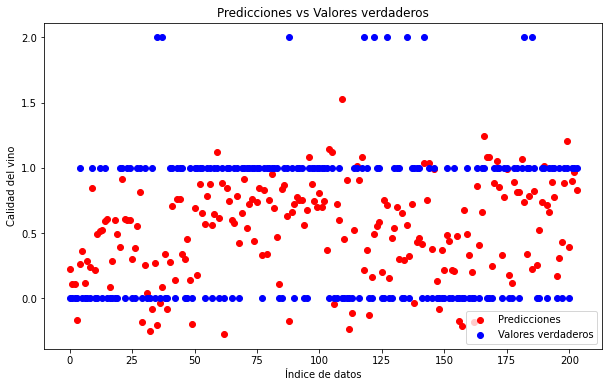

In [126]:
# Crear un array con los índices de los datos de entrada
indices = np.arange(len(X_test))

# Graficar las predicciones
plt.figure(figsize=(10, 6))
plt.scatter(indices, predictions, color='red', label='Predicciones')
plt.scatter(indices, y_test, color='blue', label='Valores verdaderos')
plt.xlabel('Índice de datos')
plt.ylabel('Calidad del vino')
plt.title('Predicciones vs Valores verdaderos')
plt.legend()
plt.show()

## Comparación de resultados

### Comparación modelos de clasificación

| Modelo ANN (Sigmoid) | Modelo ANN (TanH) |
| :-: | :-: |
| En este modelo, la función de pérdida le cuesta decrecer a lo largo de las iteraciones de cada época, por lo que al tratar de predecir la clase a la que corresponde se obtiene un average score de 0.6701 | Este modelo se logra ajustar de mejor manera al modelo que el modelo con función de activación sigmoidal, ya que el ambos accuracy crecen y el se logra apreciar una minimización efectiva de la función de pérdida, en este caso se obtiene un average score de 0.8865, superior al otro modelo  |
|Este modelo entrega una media de accuracy de 0.8089 | Este modelo entrega una media de accuracy de 0.9831 |

En conclusión, el modelo ANN con función de activación tanH, se ajustó mejor a las predicciones realizadas por lo que su rendimiento fue mucho mejor, comparando las matrices de confusión y el promedio de accuracy de cada una, asi como su decrecimiento en la función de pérdida.

### Comparación modelos de regresión

| Modelo ANN (Sigmoid) | Modelo ANN (TanH) |
| :-: | :-: |
| En este modelo se logra aprecias que la función de costo decrece de manera abrupta, estabilizandose en las primeras iteraciones a un valor muy bajo, logrando un MSE Promedio de 0.3039 y Desviación Estándar MSE de 0.0771.| Este modelo, se puede observar que la función de costo tambien disminuye de manera abruta, otorgando valores de MSE Promedio 0.3163 y Desviación Estándar MSE de 0.0731|
| El gráfico que indica los valores predichos vs los reales, muestra que el modelo se ajusta medianamente, observando a su vez algunos outliers. |  El gráfico que indica los valores predichos vs los reales, muestra que el modelo se ajusta medianamente bien, al igual que para el otro caso, observando igualmente la existencia de varios outliers.|

En conclusión, ambos modelos se ajustan de manera regular al dataset, pero a su vez generalizando de buena manera. Esto principalmente puede deberse a la cantidad de iteraciones realizadas en el train, o incluso a los datos existentes originalmente en el dataset, ya que las características que poseen puede que sean poco abordables para realizar regresión. Aunque se aprecian algunos outliers, el patrón de predicción sigue una tendencia parecida a los datos reales en cada modelo.